In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls
%cd 'drive/MyDrive/NN Proj/pytorch-ocr/src'

drive  sample_data
/content/drive/MyDrive/NN Proj/pytorch-ocr/src


In [3]:
import string
import torch

from pathlib import Path
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

from utils import CTCLabelEncoder
from train import CTCModelTrainer
from dataset import IAMLoader, split_dataset
from crnn import CRNN
from test_eval import CTCModelTesterEvaluator

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device: {device}")
torch.manual_seed(0)
%matplotlib inline

Current device: cuda


In [5]:
# Hyperparams
source_dir = Path('../data/iam/raw')
train_dir = Path('../data/iam/train')
test_dir = Path('../data/iam/test')
val_dir = Path('../data/iam/val')
info_file_path = Path('../data/iam/words.txt')

model_path = Path('../models/iam/crnn_test_2.pt')

alphabet = string.ascii_letters + string.digits + string.punctuation
label_encoder = CTCLabelEncoder(alphabet)

n_workers = 2
batch_size = 8
hidden_size = 256
vocab_size = len(alphabet) + 1 # extra character for blank symbol
dropout = 0.2
weight_decay = 0.01
momentum = 0.9
clip_norm = 1
num_epochs = 50
learning_rate = 3e-4
use_resnet18 = True
use_pretrained_model = False

print(f"Alphabet: {alphabet}")
print(f"Vocab size: {vocab_size}")

Alphabet: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
Vocab size: 95


In [6]:
split_dataset(source_dir, train_dir, test_dir, val_dir,
              train_ratio=0.7, test_ratio=0.2, val_ratio=0.1,
              iam=True, num_samples=2000)

One or more target directories are not empty. Skipping dataset split.


In [7]:
train_dataset = IAMLoader(train_dir, info_file_path)
test_dataset = IAMLoader(test_dir, info_file_path)
val_dataset = IAMLoader(val_dir, info_file_path)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=n_workers, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=n_workers, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=n_workers, shuffle=False)

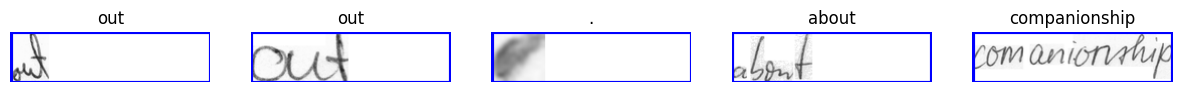

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_samples(loader, num_samples=5):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    plt.figure(figsize=(15, 5))
    for i in range(min(num_samples, len(images))):
        img = images[i].permute(1, 2, 0).numpy()
        label = labels[i]

        ax = plt.subplot(1, num_samples, i + 1)
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')

        # Draw a border around the image
        border_color = 'blue'
        border_thickness = 3
        height, width, _ = img.shape
        rect = patches.Rectangle((0, 0), width, height, linewidth=border_thickness, edgecolor=border_color, facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Example usage with the DataLoader
show_samples(val_dataloader)

In [9]:
crnn = CRNN(hidden_size=hidden_size,
            vocab_size=vocab_size,
            dropout=dropout,
            use_resnet18=use_resnet18,
            use_pretrained=use_pretrained_model
            ).to(device)

In [10]:
optimizer = torch.optim.AdamW(crnn.parameters(), lr=learning_rate, weight_decay=weight_decay)

criterion = nn.CTCLoss(blank=0, zero_infinity=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

### Train Model

In [11]:
trainer = CTCModelTrainer(model=crnn,
                          optimizer=optimizer,
                          criterion=criterion,
                          label_encoder=label_encoder,
                          train_dataloader=train_dataloader,
                          val_dataloader=val_dataloader,
                          model_path=model_path,
                          scheduler=scheduler,
                          clip_norm=clip_norm
                          )

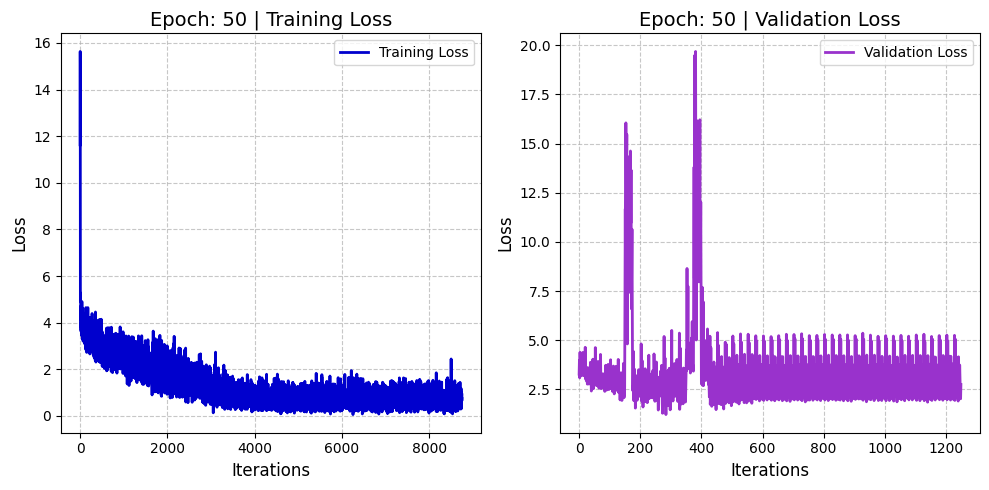

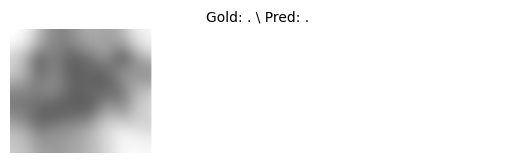

╭──────────────╮ ╭────────────────────╮ ╭──────────────────╮ ╭───────────────────────────╮
│ Epoch: 50/50 │ │ Train Loss: 0.6890 │ │ Val Loss: 2.9141 │ │ Learning Rate: 0.00000000 │
╰──────────────╯ ╰────────────────────╯ ╰──────────────────╯ ╰───────────────────────────╯

Model saved to ../models/iam/crnn_test_2.pt


In [12]:
trainer.train(num_epochs=num_epochs)

### Evaluate model

In [13]:
crnn.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [14]:
tester_evaluator = CTCModelTesterEvaluator(model=crnn,
                                           test_dataset=test_dataset,
                                           label_encoder=label_encoder,
                                           device=device,
                                           alphabet=alphabet)

In [15]:
tester_evaluator.test()

Output()

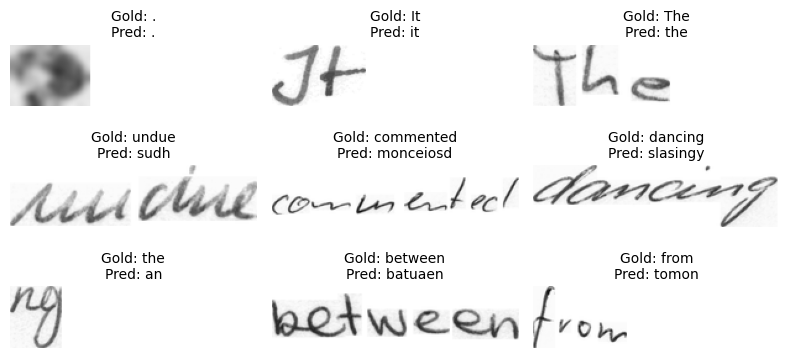

╭─────────────────────────────╮ ╭───────────────────────────────╮
│ Word-level Accuracy: 0.1975 │ │ Char-level BLEU Score: 0.4669 │
╰─────────────────────────────╯ ╰───────────────────────────────╯

In [16]:
tester_evaluator.print_results()

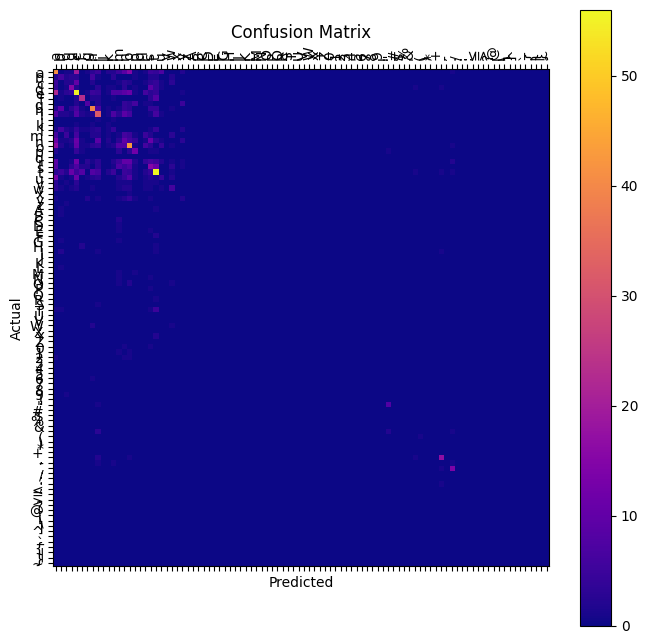

In [17]:
tester_evaluator.print_confusion_matrix()